In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io.arff import loadarff

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
DATA_PATH = 'drive/MyDrive/KP_datasets/'
# dataset_2183_cpu_act.arff       target: usr
# house_16H.arff                  target: price
# dataset_2202_elevators.arff     target: Goal
# houses.arff                     target: median_house_value

In [ ]:
DATASET_NAME = 'houses.arff'
target_col = 'median_house_value'

In [ ]:
data = loadarff(DATA_PATH + DATASET_NAME)
df = pd.DataFrame(data[0])

In [ ]:
y = df[target_col]
data = df.drop(columns=[target_col])

In [ ]:
# def preprocess_data()

In [ ]:
# filter = y <= 490000
# data = data[filter]
# y = y[filter]

In [ ]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=SEED)

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge

from sklearn.preprocessing import StandardScaler

In [ ]:

class Model(BaseEstimator):

  def __init__(self, classificator, threshold, regressors=None, cls_scaler=None, reg_scalers=[None, None]):
    super().__init__()

    self.threshold = threshold

    self.cls_model = classificator


    self.regressors = regressors

    self.scaler_cls = cls_scaler
    self.reg_scalers = reg_scalers

  def fit_classification(self, data, target):
    if self.scaler_cls is not None:
      data = self.scaler_cls.fit_transform(data)
    self.cls_model.fit(data, target)

  def fit_regressor(self, regressor, data, target, reg_num=1):
    if self.reg_scalers[reg_num - 1] is not None:
      data = self.reg_scalers[reg_num - 1].fit_transform(data)
    return regressor.fit(data, target)

  def fit(self, data, target):
    cls_target = target >= self.threshold
    self.fit_classification(data, cls_target)

    for i, regressor in enumerate(self.regressors):
      self.fit_regressor(regressor, data[cls_target == i], target[cls_target == i], reg_num=i+1)

  def predict_class(self, data, target):
    cls_target = target >= self.threshold

    if self.scaler_cls is not None:
      data = self.scaler_cls.transform(data)
    predict_classes = self.cls_model.predict(data)

    return predict_classes, cls_target

  def predict(self, data):

    result = np.zeros(data.shape[0], dtype=np.float32)
    data_for_cls = data.copy()
    if self.scaler_cls is not None:
      data_for_cls = self.scaler_cls.transform(data)
    cls_results = self.cls_model.predict(data_for_cls)

    reg_data = []
    for i, reg_scaler in enumerate(self.reg_scalers):
      if reg_scaler is not None:
        reg_data.append(reg_scaler.transform(data[cls_results == i]))
      else:
        reg_data.append(data[cls_results == i])
      result[cls_results == i] = self.regressors[i].predict(reg_data[i])

    return result



In [ ]:
# filter = y_train <= 490000
# X_train = X_train[filter]
# y_train = y_train[filter]

<Axes: xlabel='median_house_value', ylabel='Count'>

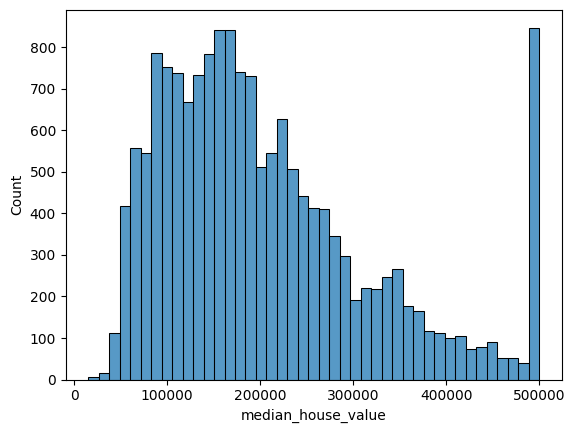

In [ ]:
sns.histplot(y_train)

In [ ]:
from sklearn.svm import SVC

In [ ]:
# classificator = LogisticRegression(C=3, max_iter=10000)
classificator = SVC(C=20, kernel='rbf', max_iter=50000)

scaler_cls = StandardScaler()
# scaler_cls = None

reg_scalers = [StandardScaler(), StandardScaler()]
# reg_scalers = [StandardScaler(), None]
# reg_scalers = [None, StandardScaler()]
# reg_scalers = [None, None]

regressors = [Lasso(alpha=1, max_iter=20000), Lasso(alpha=3, max_iter=20000)]
# regressors = [LinearRegression(), LinearRegression()]

# 'poly'

In [ ]:
threshold = 300000

In [ ]:
model = Model(classificator, threshold, regressors=regressors, cls_scaler=scaler_cls, reg_scalers=reg_scalers)

In [ ]:
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.model_selection import KFold

from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
metrics_dict = {}

metrics_dict['metrics'] = {'r2': r2_score(y_test, y_pred),
                            'MAE': mean_absolute_error(y_test, y_pred),
                            'MSE': mean_squared_error(y_test, y_pred),
                            'MAPE': mean_absolute_percentage_error(y_test, y_pred)}

In [ ]:
metrics_dict

{'metrics': {'r2': 0.6628447487419742,
  'MAE': 46373.22405745632,
  'MSE': 4418112683.095836,
  'MAPE': 0.26530039735060373}}

In [ ]:
predict_classes, true_classes = model.predict_class(X_test, y_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(true_classes, predict_classes)

0.9115794573643411

In [ ]:
# dataset_2183_cpu_act.arff:

# thr = 65
# classificator = LogisticRegression(C=2, max_iter=10000)
# scaler_cls = StandardScaler()
# reg_scalers = [StandardScaler(), None]
# regressors = [Lasso(alpha=1, max_iter=10000), Lasso(alpha=2, max_iter=10000)]

# {'metrics': {'r2': 0.960826925734682,
#   'MAE': 2.150114833817961,
#   'MSE': 11.738617654251021,
#   'MAPE': 408490187290832.7}}

# acc: 0.9890176937156803

In [ ]:
# house_16H.arff

# threshold = 70000
# classificator = SVC(C=3, kernel='rbf', max_iter=100000)

# scaler_cls = StandardScaler()
# reg_scalers = [StandardScaler(), StandardScaler()]
# regressors = [Lasso(alpha=1, max_iter=20000), Lasso(alpha=1, max_iter=20000)]

# {'metrics': {'r2': 0.441646082060712,
#   'MAE': 20286.62057431832,
#   'MSE': 1568494462.4838796,
#   'MAPE': 6.923108603508425e+17}}

# accuracy = 0.9084924292297564

In [ ]:
# dataset_2202_elevators.arff

# classificator = LogisticRegression(C=5, max_iter=10000)

# scaler_cls = StandardScaler()

# reg_scalers = [StandardScaler(), StandardScaler()]
# regressors = [LinearRegression(), LinearRegression()]


# {'metrics': {'r2': 0.8748573120876797,
#   'MAE': 0.001664089481032128,
#   'MSE': 5.316820329138507e-06,
#   'MAPE': 0.07715684075642518}}


# accuracy = 0.9743975903614458

In [ ]:
# # houses.arff

# classificator = SVC(C=20, kernel='rbf', max_iter=50000)
# scaler_cls = StandardScaler()
# reg_scalers = [StandardScaler(), StandardScaler()]
# regressors = [Lasso(alpha=1, max_iter=20000), Lasso(alpha=3, max_iter=20000)]

# {'metrics': {'r2': 0.6628447487419742,
#   'MAE': 46373.22405745632,
#   'MSE': 4418112683.095836,
#   'MAPE': 0.26530039735060373}}
# accuracy = 0.9115794573643411

In [33]:
import pandas as pd

df = pd.DataFrame({'R2': [0.84719, 0.63596, 0.66284], 'MAE': [29578.008, 50813.0426, 46373.224]}, index=['CatBoost', 'Linreg', 'Ours'])


In [34]:
df

,R2,MAE
CatBoost,0.84719,29578.0080
Linreg,0.63596,50813.0426
Ours,0.66284,46373.2240


In [35]:
df.to_csv('houses.csv')

In [ ]:

# df = pd.DataFrame({'R2': [0.98399, 0.96083], 'MAE': [1.59156, 2.15011]}, index=['CatBoost', 'Ours'])
# df = pd.DataFrame({'R2': [0.65513, 0.44165], 'MAE': [15810.4693, 20286.62057]}, index=['CatBoost', 'Ours'])
# df = pd.DataFrame({'R2': [0.8991, 0.874857], 'MAE': [0.00154, 0.00166]}, index=['CatBoost', 'Ours'])
# df = pd.DataFrame({'R2': [0.84719, 0.66284], 'MAE': [29578.008, 46373.224]}, index=['CatBoost', 'Ours'])

In [ ]:
# df = pd.DataFrame({'R2': [0.98399, 0.71455, 0.96083], 'MAE': [1.59156, 6.14158, 2.15011]}, index=['CatBoost', 'Linreg', 'Ours'])
# df = pd.DataFrame({'R2': [0.65513, 0.25386 , 0.44165], 'MAE': [15810.4693, 25497.7456, 20286.62057]}, index=['CatBoost', 'Linreg', 'Ours'])

# df = pd.DataFrame({'R2': [0.84719, 0.63596, 0.66284], 'MAE': [29578.008, 50813.0426, 46373.224]}, index=['CatBoost', 'Linreg', 'Ours'])

